# Bevezetés

A mai laboron egy YOLO objektumdetektáló háló implementációja lesz a cél

## Installáció

In [ ]:
!pip3 install torch torchvision

## Installáció ellenőrzése

In [ ]:
!nvcc --version
import torch
print(torch.cuda.is_available())

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
True


## Adatbázis letöltése

In [ ]:
!wget http://deeplearning.iit.bme.hu/Public/ROBO/ROBO_Finetune.zip
!unzip -qq ROBO_Finetune.zip
!rm ROBO_Finetune.zip
!mkdir Data
!mv Finetune Data/Finetune

--2024-03-20 18:30:54--  http://deeplearning.iit.bme.hu/Public/ROBO/ROBO_Finetune.zip
Resolving deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)... 152.66.243.112
Connecting to deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)|152.66.243.112|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://deeplearning.iit.bme.hu/Public/ROBO/ROBO_Finetune.zip [following]
--2024-03-20 18:30:55--  https://deeplearning.iit.bme.hu/Public/ROBO/ROBO_Finetune.zip
Connecting to deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)|152.66.243.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 454946976 (434M) [application/zip]
Saving to: ‘ROBO_Finetune.zip’

ROBO_Finetune.zip   100%[===================>] 433.87M  2.64MB/s    in 1m 54s  

2024-03-20 18:32:49 (3.82 MB/s) - ‘ROBO_Finetune.zip’ saved [454946976/454946976]



# Megoldás

## Label elolvasása

In [ ]:
f = open("Data/Finetune/train/0.txt")
print(f.read())

1 0.45625 0.9645833333333333 0.1875 0.0625
3 0.15 0.3416666666666667 0.1375 0.26666666666666666
3 0.29375 0.32916666666666666 0.125 0.2625
3 0.384375 0.3125 0.09375 0.22916666666666666
3 0.4734375 0.30625 0.08125 0.21666666666666667
3 0.540625 0.3020833333333333 0.078125 0.20416666666666666
3 0.615625 0.2916666666666667 0.065625 0.15
3 0.671875 0.28541666666666665 0.05625 0.14166666666666666



## Dataset készítése

In [ ]:
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class ListDataset(Dataset):
  def __init__(self, list_path, img_size=(384,512)):
    self.img_files = [list_path + img for img in glob.glob1(list_path,"*.png")]
    self.label_files = [path.replace('images', 'labels').replace('.png', '.txt').replace('.jpg', '.txt') for path in self.img_files]
    self.img_shape = img_size
    self.transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])

  def __getitem__(self, index):

    #---------
    #  Image
    #---------

    img_path = self.img_files[index % len(self.img_files)].rstrip()
    img = Image.open(img_path).convert('RGB')

    input_img = self.transform(img)

    #---------
    #  Label
    #---------

    label_path = self.label_files[index % len(self.img_files)].rstrip()

    labels = None
    if os.path.exists(label_path):
      labels = np.loadtxt(label_path).reshape(-1, 5)
    # Fill matrix
    filled_labels = np.zeros((50, 5))
    if labels is not None:
        filled_labels[range(len(labels))[:50]] = labels[:50]
    filled_labels = torch.from_numpy(filled_labels)

    return img_path, input_img, filled_labels

  def __len__(self):
    return len(self.img_files)

## Modell készítése

### IoU számítás

In [ ]:
def bbox_iou(box1, box2, x1y1x2y2=True):
  """
  Returns the IoU of two bounding boxes
  """
  if not x1y1x2y2:
    # Transform from center and width to exact coordinates
    b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
    b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
    b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
    b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
  else:
    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

  # get the corrdinates of the intersection rectangle
  inter_rect_x1 = torch.max(b1_x1, b2_x1)
  inter_rect_y1 = torch.max(b1_y1, b2_y1)
  inter_rect_x2 = torch.min(b1_x2, b2_x2)
  inter_rect_y2 = torch.min(b1_y2, b2_y2)
  # Intersection area
  inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
    inter_rect_y2 - inter_rect_y1 + 1, min=0
  )
  # Union Area
  b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
  b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

  iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

  return iou

### Helyes válaszok előállítása

In [ ]:
import math

# w,h is the GT width and height, anchors contain the anchor
def get_anchor_ious(w,h,anchors):
    # TODO: create BB for GT [0,0,w,h]
    gt_bb = torch.tensor([0,0,w,h])

    # TODO: create BBs for anchors:
    #[[0, 0, w1, h1]]
    #[      ...     ]
    #[[0, 0, wA, hA]]
    anchor_bbs = torch.tensor([
      [0, 0, anchors[i][0], anchors[i][1]] for i in range(anchors.shape[0])
    ])

    # Simply call bbox_iou between these and return
    return bbox_iou(gt_bb.repeat(anchors.shape[0], 1), anchor_bbs, False)

def build_targets(pred_boxes, pred_confs, pred_classes, target, anchors, num_anchors,
                  num_classes, grid_size_y, grid_size_x, ignore_thres, img_dim):
  nB = target.size(0)
  nA = num_anchors
  nC = num_classes
  sGx = grid_size_x
  sGy = grid_size_y

  # Masks: mask is one for the best bounding box
  mask = torch.zeros(nB, nA, sGy, sGx)

  # Conf mask is one for BBs, where the confidence is enforced to match target
  # So for predictions where the IoU is not maximal, but good, we'll set conf_mask to 0
  conf_mask = torch.ones(nB, nA, sGy, sGx)

  # Target values for x,y,w,h and confidence and class
  tx = torch.zeros(nB, nA, sGy, sGx)
  ty = torch.zeros(nB, nA, sGy, sGx)
  tw = torch.zeros(nB, nA, sGy, sGx)
  th = torch.zeros(nB, nA, sGy, sGx)

  # These have values for: [Batch, Anchors, Grid Height, Grid Width]
  tconf = torch.ByteTensor(nB, nA, sGy, sGx).fill_(0)
  tcls = torch.ByteTensor(nB, nA, sGy, sGx).fill_(0)

  nGT = 0
  nCorrect = 0

  # TODO: Logic
  # For all images in batch
  for b in range(nB):
    # For all boxes in the GT list
    for t in range(target.shape[1]):
      # If the GT is empty (all GT lists have 50 objects, and the placeholders are all 0)
      if target[b, t].sum() == 0:
        continue
      # Number of objetcs increment
      nGT += 1

      # Convert to position relative to box
      t_class = target[b, t, 0].long()
      gx = target[b, t, 1] * sGx
      gy = target[b, t, 2] * sGy
      gw = target[b, t, 3] * sGx
      gh = target[b, t, 4] * sGy

      # Get grid box indices
      gi = int(gx)
      gj = int(gy)

      # TODO: Get IoU values between the anchors, and the GT box (use gw and gh for the GT box)
      # Tip: Use the get_anchor_ious function
      anchor_ious = get_anchor_ious(gw, gh, anchors)

      # TODO: Set the conf_mask to zero for all good matches
      # Tip: Use ignore_thres to decide whether the IoU is good enough
      # Tip: you also need to index conf_max using the batch, and gi, gj (scroll back and look at the size)
      conf_mask[b, anchor_ious > ignore_thres, gj, gi] = 0

      # TODO: Find the best matching box (np.argmax)
      # Tip: Use the anchor_ious array
      best_n = np.argmax(anchor_ious)

      # TODO: Set mask and conf_mask to 1 for the best matching output
      # Tip: mask and conf_mask are 4D arrays, so you need to index them using the batch, and gi, gj
      mask[b, best_n, gj, gi] = 1
      conf_mask[b, best_n, gj, gi] = 1

      # TODO: Set target x and y coordinates for the best maching box (tx and ty are the arrays)
      # Tip: The x and y target needs to be the difference between the GT box coord (gx, gy) and the grid index (gi, gj)
      tx[b, best_n, gj, gi] = gx - gi
      ty[b, best_n, gj, gi] = gy - gj

      # TODO: Set the target width and height for the best maching box (tw and th are the arrays)
      # Tip: gw = anchor_w * exp(tw), so compute tw (and th similarly) from that
      tw[b, best_n, gj, gi] = math.log(gw / anchors[best_n, 0] + 1e-16)
      th[b, best_n, gj, gi] = math.log(gh / anchors[best_n, 1] + 1e-16)

      # TODO: Set the target confidence to 1 and the target class to t_class for the best maching box
      tconf[b, best_n, gj, gi] = 1
      tcls[b, best_n, gj, gi] = t_class

      # TODO: Get the actual predicted bounding box (pred_boxes has all the predictions), and unsqueeze
      pred_bb = pred_boxes[b, best_n, gj, gi].unsqueeze(0)

      # TODO: Get the actual predicted class (pred_classes has all of them) (use np.argmax)
      pred_cls = np.argmax(pred_classes[b, best_n, gj, gi])

      # TODO: Get the actual predicted confidence score (pred_conf)
      pred_conf = pred_confs[b, best_n, gj, gi]

      # Create ground truth box
      gt_box = torch.FloatTensor(np.array([gx, gy, gw, gh])).unsqueeze(0)

      # TODO: If the IoU > 0.5 and the predicted confidence is also > 0.5 and the predicted class is correct
      # Then increment nCorrect
      # Tip bbox_iou needs to be called with x1y1x2y2=False argument here
      iou = bbox_iou(gt_box, pred_bb, x1y1x2y2=False)
      if iou > 0.5 and pred_conf > 0.5 and pred_cls == t_class:
        nCorrect += 1



  return nGT, nCorrect, mask, conf_mask, tx, ty, tw, th, tconf, tcls

### YOLO költségfüggvény megírása

In [ ]:
class YOLOLayer(nn.Module):
  """Detection layer"""

  def __init__(self, anchors, num_classes, img_dim):
    super(YOLOLayer, self).__init__()
    self.anchors = anchors
    self.num_anchors = len(anchors)
    self.num_classes = num_classes
    self.bbox_attrs = 5 + num_classes
    self.image_dim = img_dim
    self.ignore_thres = 0.5
    self.lambda_coord = 1

    self.mse_loss = nn.MSELoss(reduction='mean')  # Coordinate loss
    self.bce_loss = nn.BCELoss(reduction='mean')  # Confidence loss
    self.ce_loss = nn.CrossEntropyLoss(reduction='mean')  # Class loss

  def forward(self, x, targets=None):
    nA = self.num_anchors
    nB = x.size(0)
    nGy = x.size(2)
    nGx = x.size(3)
    stride = self.image_dim[0] / nGy

    # Tensors for cuda support
    FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
    LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
    ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

    # Calculate offsets for each grid ngx x ngy- os grid 0 1 2 3 soronként és oszloponként
    grid_x = torch.arange(nGx).repeat(nGy, 1).view([1, 1, nGy, nGx]).type(FloatTensor)
    grid_y = torch.arange(nGy).repeat(nGx, 1).t().view([1, 1, nGy, nGx]).type(FloatTensor)

    # Scale down anchors to be in grid cells, instead of pixels (build_target expects them like that)
    scaled_anchors = FloatTensor([(a_w / stride, a_h / stride) for a_w, a_h in self.anchors]) #lenormáljuk az anchorokat stride-al
    anchor_w = scaled_anchors[:, 0].view((1, nA, 1, 1))
    anchor_h = scaled_anchors[:, 1].view((1, nA, 1, 1))

    # Reshape x: [batchSize x nGy x nGx x numAnchors*(5+numClass)] -> [batchSize x numAnchors x nGy x nGx x (5+numClass)]
    prediction = x.view(nB, nA, self.bbox_attrs, nGy, nGx).permute(0, 1, 3, 4, 2).contiguous()

    # TODO: Get outputs
    # Tip: Predictions are in the prediction array
    # Tip: You can write prediction[..., index] to get every element in all dimensions, and index in the last
    # Tip: Use sigmoid activation for x,y and confidence (no activation needed for the others)
    x = torch.sigmoid(prediction[..., 0]) # 0th element
    y = torch.sigmoid(prediction[..., 1]) # 1st element
    w = prediction[..., 2] # 2nd element
    h = prediction[..., 3] # 3rd element
    pred_conf = torch.sigmoid(prediction[..., 4]) # 4th element
    pred_cls = prediction[..., 5:] # 5th to last element


    # TODO: Create predicted boxes (pred_boxes[..., 0] will be x, and so on)
    # Tip: you need to add the grid coordinates to the x and y values (there's a grid_x and grid_y a few lines up)
    # Tip: Make sure you detach x, y, w and h in these operations, as we don't want the next operations be on the computational graph
    # Tip: For w and h you need to use the YOLO w-h formula (width = exp(w)*anchor_w)
    # anchor_w and anchor_h also exist here
    pred_boxes = FloatTensor(prediction[..., :4].shape)
    pred_boxes[..., 0] = x.detach() + grid_x
    pred_boxes[..., 1] = y.detach() + grid_y
    pred_boxes[..., 2] = torch.exp(w.detach()) * anchor_w
    pred_boxes[..., 3] = torch.exp(h.detach()) * anchor_h

    # Training
    if targets is not None:

      if x.is_cuda:
        self.mse_loss = self.mse_loss.cuda()
        self.bce_loss = self.bce_loss.cuda()
        self.ce_loss = self.ce_loss.cuda()

      nGT, nCorrect, mask, conf_mask, tx, ty, tw, th, tconf, tcls = build_targets(
        pred_boxes=pred_boxes.cpu().detach(),
        pred_confs=pred_conf.cpu().detach(),
        pred_classes=pred_cls.cpu().detach(),
        target=targets.cpu().detach(),
        anchors=scaled_anchors.cpu().detach(),
        num_anchors=nA,
        num_classes=self.num_classes,
        grid_size_y=nGy,
        grid_size_x=nGx,
        ignore_thres=self.ignore_thres,
        img_dim=self.image_dim,
      )

      # TODO: Compute recall and precision
      # tip: You have everything you need for Recall (build_targets returns them)
      # Tip: For precision you need to compute the number of objects predicted by YOLO
      # Tip: "how many times is pred_conf > 0.5" gives you that
      recall = nCorrect / nGT
      precision = nCorrect / pred_conf[pred_conf > 0.5].size(0)

      # Handle masks
      mask = mask.type(ByteTensor).bool()
      conf_mask = conf_mask.type(ByteTensor).bool()

      # Handle target variables
      tx = tx.type(FloatTensor)
      ty = ty.type(FloatTensor)
      tw = tw.type(FloatTensor)
      th = th.type(FloatTensor)
      tconf = tconf.type(FloatTensor)
      tcls = tcls.type(LongTensor)

      # Get conf mask where conf should be 1
      conf_mask_true = mask

      # Get conf mask where conf should be 0
      # where mask is 1 we have the best BB, conf mask is always 1 there
      # where mask is 0 we don't have the best BB, if conf_mask is 1, then it is a bad BB and should be punished
      # where mask is 0 we don't have the best BB, if conf_mask is 0, then it is a good BB and shouldn't be punished
      conf_mask_false = conf_mask ^ mask # XOR

      # TODO: Mask outputs to ignore non-existing objects
      # Tip: Losses are between predictions (x,y,w,h, pred_conf, pred_class)
      # and targets (tx, ty, tw, th, tconf, tcls)
      # But you need to use the mask to only compute the loss in places where there is a best BB
      # x,y,w,h losses are Mean Squared Error (self.MSE)
      loss_x = self.mse_loss(x[mask], tx[mask])
      loss_y = self.mse_loss(y[mask], ty[mask])
      loss_w = self.mse_loss(w[mask], tw[mask])
      loss_h = self.mse_loss(h[mask], th[mask])

      # Tip: CLS loss is Cross-Entropy (self.CE)
      loss_cls = self.ce_loss(pred_cls[mask], tcls[mask])

      # Tip: Conf loss is binary CE (self.BCE)
      # Here the loss is a weighted sum of 2 parts (try with weights 10 and 1)
      # First part is BCE where conf_mask_true is 1 (here we tell YOLO that it should predic an object)
      # Second part is BCE where conf_mask_false is 1 (we tell YOLO that it shouldn't predict objects here)
      loss_conf = 10 * self.bce_loss(pred_conf[conf_mask_true], tconf[conf_mask_true]) + \
                   self.bce_loss(pred_conf[conf_mask_false], tconf[conf_mask_false])

      # TODO: sum all the losses
      loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls


      return (
        loss,
        loss_x.item(),
        loss_y.item(),
        loss_w.item(),
        loss_h.item(),
        loss_conf.item(),
        loss_cls.item(),
        recall,
        precision,
      )

    else:
      # If not in training phase return predictions
      output = torch.cat(
        (
          pred_boxes.view(nB, -1, 4) * stride,
          pred_conf.view(nB, -1, 1),
          pred_cls.view(nB, -1, self.num_classes),
        ),
        -1,
      )
      return output

### Modell készítése

In [ ]:
import torch
import torch.nn as nn

class Conv(nn.Module):
  def __init__(self, inplanes, planes, size=3, stride=1):
    super(Conv, self).__init__()
    self.conv = nn.Conv2d(inplanes, planes, kernel_size=size, padding=size // 2, stride=stride)
    self.bn = nn.BatchNorm2d(planes)

  def forward(self, x):
    return self.bn(torch.relu(self.conv(x)))

class YOLO(nn.Module):
  def __init__(self,planes,nClass,anchors):
    super(YOLO, self).__init__()
    nB = len(anchors)

    nOut = nB*(5+nClass)

    self.c1 = Conv(3,planes)
    self.d1 = Conv(planes,planes*2,stride=2)
    self.c2 = Conv(planes*2,planes*2)
    self.d2 = Conv(planes*2,planes*4,stride=2)
    self.c3 = Conv(planes*4,planes*4)
    self.d3 = Conv(planes*4,planes*8,stride=2)
    self.c4 = Conv(planes*8,planes*8)
    self.d4 = Conv(planes*8,planes*16,stride=2)
    self.c5 = Conv(planes*16,planes*16)
    self.d5 = Conv(planes*16,planes*32,stride=2)
    self.c6 = Conv(planes*32,planes*32)
    self.c7 = Conv(planes*32,planes*32)

    self.bbox_head = nn.Conv2d(planes*32, nOut, kernel_size=1)

    self.loss = YOLOLayer(anchors, nClass, (384,512))

  def forward(self, x, targets=None):
    x = self.d1(self.c1(x))
    x = self.d2(self.c2(x))
    x = self.d3(self.c3(x))
    x = self.d4(self.c4(x))
    x = self.d5(self.c5(x))
    x = self.bbox_head(self.c7(self.c6(x)))

    return self.loss(x, targets)


## Tanítás

<ipython-input-9-fff2f139004a>:35: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  scaled_anchors = FloatTensor([(a_w / stride, a_h / stride) for a_w, a_h in self.anchors]) #lenormáljuk az anchorokat stride-al


[Epoch 1/80][Losses: x 0.085957, y 0.077827, w 0.182947, h 0.159238, conf 1.879293, cls 0.733683, total 3.118944, recall: 0.51053, precision: 0.00493]


[Epoch 2/80][Losses: x 0.074513, y 0.056488, w 0.093381, h 0.082104, conf 1.200136, cls 0.396921, total 1.903544, recall: 0.70818, precision: 0.00889]


[Epoch 3/80][Losses: x 0.064713, y 0.043739, w 0.074243, h 0.070489, conf 1.002724, cls 0.251173, total 1.507081, recall: 0.79206, precision: 0.01229]


[Epoch 4/80][Losses: x 0.056792, y 0.037096, w 0.064801, h 0.063118, conf 0.880320, cls 0.170221, total 1.272349, recall: 0.84569, precision: 0.01568]


[Epoch 5/80][Losses: x 0.047325, y 0.030420, w 0.052634, h 0.050054, conf 0.721707, cls 0.099325, total 1.001465, recall: 0.89496, precision: 0.02113]


[Epoch 6/80][Losses: x 0.040204, y 0.026338, w 0.046617, h 0.043554, conf 0.561778, cls 0.055564, total 0.774055, recall: 0.91992, precision: 0.03017]


[Epoch 7/80][Losses: x 0.035931, y 0.024192, w 0.044378, h 0.036958, conf 0.445781, cls 0.042219, total 0.629458, recall: 0.93492, precision: 0.03945]


[Epoch 8/80][Losses: x 0.039374, y 0.029488, w 0.054119, h 0.045304, conf 0.550199, cls 0.084641, total 0.803124, recall: 0.90266, precision: 0.03379]


[Epoch 9/80][Losses: x 0.042441, y 0.032590, w 0.055020, h 0.053301, conf 0.617195, cls 0.111920, total 0.912467, recall: 0.88711, precision: 0.02748]


[Epoch 10/80][Losses: x 0.037006, y 0.027791, w 0.048796, h 0.042475, conf 0.451287, cls 0.063048, total 0.670403, recall: 0.91922, precision: 0.03763]


[Epoch 11/80][Losses: x 0.031979, y 0.023430, w 0.037280, h 0.032798, conf 0.332016, cls 0.029064, total 0.486567, recall: 0.94077, precision: 0.05121]


[Epoch 12/80][Losses: x 0.029644, y 0.020944, w 0.033213, h 0.028035, conf 0.277860, cls 0.020860, total 0.410555, recall: 0.94780, precision: 0.06237]


[Epoch 13/80][Losses: x 0.025673, y 0.018434, w 0.028684, h 0.026872, conf 0.212828, cls 0.016495, total 0.328986, recall: 0.95981, precision: 0.07949]


[Epoch 14/80][Losses: x 0.023152, y 0.016604, w 0.027029, h 0.023432, conf 0.183744, cls 0.011951, total 0.285912, recall: 0.96532, precision: 0.09380]


[Epoch 15/80][Losses: x 0.022187, y 0.016139, w 0.027329, h 0.025807, conf 0.179145, cls 0.011377, total 0.281984, recall: 0.96828, precision: 0.09562]


[Epoch 16/80][Losses: x 0.020057, y 0.014965, w 0.026188, h 0.021455, conf 0.150564, cls 0.009801, total 0.243031, recall: 0.97043, precision: 0.10955]


[Epoch 17/80][Losses: x 0.018318, y 0.013778, w 0.024205, h 0.020439, conf 0.147291, cls 0.011067, total 0.235098, recall: 0.97224, precision: 0.12069]


[Epoch 18/80][Losses: x 0.027465, y 0.021839, w 0.039176, h 0.036175, conf 0.386730, cls 0.042615, total 0.554000, recall: 0.93956, precision: 0.06412]


[Epoch 19/80][Losses: x 0.035920, y 0.029297, w 0.051619, h 0.044456, conf 0.575486, cls 0.098322, total 0.835099, recall: 0.89839, precision: 0.03270]


[Epoch 20/80][Losses: x 0.030040, y 0.022974, w 0.042456, h 0.038386, conf 0.358374, cls 0.047879, total 0.540108, recall: 0.93740, precision: 0.04892]


[Epoch 21/80][Losses: x 0.023869, y 0.018389, w 0.031464, h 0.025220, conf 0.226635, cls 0.018560, total 0.344139, recall: 0.96014, precision: 0.07491]


[Epoch 22/80][Losses: x 0.020492, y 0.015312, w 0.025125, h 0.020964, conf 0.164446, cls 0.010305, total 0.256645, recall: 0.96661, precision: 0.09893]


[Epoch 23/80][Losses: x 0.016359, y 0.012624, w 0.020998, h 0.017138, conf 0.125114, cls 0.006103, total 0.198336, recall: 0.97390, precision: 0.12867]


[Epoch 24/80][Losses: x 0.015621, y 0.012468, w 0.019445, h 0.016650, conf 0.117532, cls 0.006070, total 0.187786, recall: 0.97526, precision: 0.13521]


[Epoch 25/80][Losses: x 0.012254, y 0.009787, w 0.016432, h 0.013846, conf 0.081494, cls 0.002917, total 0.136730, recall: 0.97709, precision: 0.17809]


[Epoch 26/80][Losses: x 0.010109, y 0.008069, w 0.014159, h 0.012207, conf 0.063668, cls 0.001907, total 0.110120, recall: 0.97852, precision: 0.21352]


[Epoch 27/80][Losses: x 0.009281, y 0.007543, w 0.012386, h 0.011921, conf 0.061706, cls 0.002355, total 0.105192, recall: 0.97835, precision: 0.22142]


[Epoch 28/80][Losses: x 0.011182, y 0.008794, w 0.015746, h 0.013783, conf 0.090128, cls 0.003979, total 0.143612, recall: 0.97686, precision: 0.18453]


[Epoch 29/80][Losses: x 0.015226, y 0.012781, w 0.021949, h 0.018938, conf 0.152140, cls 0.009404, total 0.230437, recall: 0.97384, precision: 0.13014]


[Epoch 30/80][Losses: x 0.016360, y 0.012751, w 0.024850, h 0.021786, conf 0.149713, cls 0.010804, total 0.236263, recall: 0.97301, precision: 0.12051]


[Epoch 31/80][Losses: x 0.014855, y 0.011497, w 0.021662, h 0.020105, conf 0.131128, cls 0.009107, total 0.208354, recall: 0.97286, precision: 0.13211]


[Epoch 32/80][Losses: x 0.012961, y 0.010486, w 0.021537, h 0.018217, conf 0.111518, cls 0.016925, total 0.191644, recall: 0.97300, precision: 0.14814]


[Epoch 33/80][Losses: x 0.012114, y 0.008986, w 0.017279, h 0.016237, conf 0.095927, cls 0.007381, total 0.157924, recall: 0.97715, precision: 0.16780]


[Epoch 34/80][Losses: x 0.011287, y 0.008682, w 0.016642, h 0.015958, conf 0.089647, cls 0.004178, total 0.146396, recall: 0.97864, precision: 0.17590]


[Epoch 35/80][Losses: x 0.009604, y 0.008020, w 0.015705, h 0.012529, conf 0.071035, cls 0.003166, total 0.120058, recall: 0.97847, precision: 0.20917]


[Epoch 36/80][Losses: x 0.007254, y 0.006201, w 0.011629, h 0.010715, conf 0.044220, cls 0.003355, total 0.083374, recall: 0.97828, precision: 0.26974]


[Epoch 37/80][Losses: x 0.005479, y 0.004609, w 0.008903, h 0.008349, conf 0.031335, cls 0.001426, total 0.060101, recall: 0.97926, precision: 0.32891]


[Epoch 38/80][Losses: x 0.004523, y 0.003976, w 0.007702, h 0.007255, conf 0.025396, cls 0.001504, total 0.050355, recall: 0.97944, precision: 0.35998]


[Epoch 39/80][Losses: x 0.003817, y 0.003582, w 0.006444, h 0.005400, conf 0.020414, cls 0.000817, total 0.040475, recall: 0.97799, precision: 0.39815]


[Epoch 40/80][Losses: x 0.003285, y 0.002984, w 0.005776, h 0.004534, conf 0.016847, cls 0.000894, total 0.034319, recall: 0.97870, precision: 0.43305]


[Epoch 41/80][Losses: x 0.002934, y 0.002826, w 0.005827, h 0.005021, conf 0.014693, cls 0.001573, total 0.032874, recall: 0.97863, precision: 0.45348]


[Epoch 42/80][Losses: x 0.002931, y 0.002806, w 0.005476, h 0.004600, conf 0.013977, cls 0.002197, total 0.031987, recall: 0.97873, precision: 0.47062]


[Epoch 43/80][Losses: x 0.003103, y 0.002790, w 0.006409, h 0.004680, conf 0.013278, cls 0.004093, total 0.034353, recall: 0.97820, precision: 0.46845]


[Epoch 44/80][Losses: x 0.002615, y 0.002482, w 0.005382, h 0.004775, conf 0.011129, cls 0.001656, total 0.028039, recall: 0.97914, precision: 0.49178]


[Epoch 45/80][Losses: x 0.002274, y 0.002374, w 0.004964, h 0.004387, conf 0.009964, cls 0.003122, total 0.027085, recall: 0.97879, precision: 0.50509]


[Epoch 46/80][Losses: x 0.005991, y 0.005261, w 0.010736, h 0.008611, conf 0.059593, cls 0.006337, total 0.096529, recall: 0.97615, precision: 0.38618]


[Epoch 47/80][Losses: x 0.041747, y 0.033593, w 0.061827, h 0.051601, conf 0.889323, cls 0.161186, total 1.239277, recall: 0.86641, precision: 0.03318]


[Epoch 48/80][Losses: x 0.037967, y 0.030095, w 0.054322, h 0.046977, conf 0.512096, cls 0.103430, total 0.784888, recall: 0.89770, precision: 0.03468]


[Epoch 49/80][Losses: x 0.028049, y 0.021601, w 0.041767, h 0.032690, conf 0.296823, cls 0.036504, total 0.457435, recall: 0.94342, precision: 0.05744]


[Epoch 50/80][Losses: x 0.021291, y 0.016242, w 0.031068, h 0.025164, conf 0.187967, cls 0.013502, total 0.295234, recall: 0.96636, precision: 0.08857]


[Epoch 51/80][Losses: x 0.017819, y 0.013139, w 0.024881, h 0.020530, conf 0.126813, cls 0.009349, total 0.212530, recall: 0.97254, precision: 0.12331]


[Epoch 52/80][Losses: x 0.014285, y 0.010670, w 0.019790, h 0.016701, conf 0.092013, cls 0.003324, total 0.156783, recall: 0.97579, precision: 0.15880]


[Epoch 53/80][Losses: x 0.011331, y 0.008953, w 0.015686, h 0.014428, conf 0.076680, cls 0.003323, total 0.130400, recall: 0.97915, precision: 0.19077]


[Epoch 54/80][Losses: x 0.011298, y 0.008810, w 0.016566, h 0.013718, conf 0.099349, cls 0.004270, total 0.154012, recall: 0.97767, precision: 0.17381]


[Epoch 55/80][Losses: x 0.010426, y 0.008231, w 0.014559, h 0.013928, conf 0.080418, cls 0.004026, total 0.131589, recall: 0.97872, precision: 0.18793]


[Epoch 56/80][Losses: x 0.008698, y 0.007032, w 0.012717, h 0.011892, conf 0.066846, cls 0.001704, total 0.108888, recall: 0.97786, precision: 0.21418]


[Epoch 57/80][Losses: x 0.008446, y 0.006825, w 0.012945, h 0.011676, conf 0.061779, cls 0.003230, total 0.104900, recall: 0.97864, precision: 0.22950]


[Epoch 58/80][Losses: x 0.006860, y 0.005633, w 0.010547, h 0.010045, conf 0.046528, cls 0.001216, total 0.080830, recall: 0.97941, precision: 0.27032]


[Epoch 59/80][Losses: x 0.006118, y 0.004984, w 0.010028, h 0.010045, conf 0.039740, cls 0.001467, total 0.072381, recall: 0.97991, precision: 0.29330]


[Epoch 60/80][Losses: x 0.004998, y 0.004215, w 0.007931, h 0.007755, conf 0.029517, cls 0.001336, total 0.055753, recall: 0.97877, precision: 0.33618]


[Epoch 61/80][Losses: x 0.004036, y 0.003604, w 0.006805, h 0.006496, conf 0.022562, cls 0.001070, total 0.044573, recall: 0.97853, precision: 0.38236]


[Epoch 62/80][Losses: x 0.003484, y 0.003072, w 0.005811, h 0.005499, conf 0.018482, cls 0.001008, total 0.037355, recall: 0.97848, precision: 0.41462]


[Epoch 63/80][Losses: x 0.003138, y 0.002852, w 0.005107, h 0.005366, conf 0.015231, cls 0.001291, total 0.032984, recall: 0.97790, precision: 0.44945]


[Epoch 64/80][Losses: x 0.002900, y 0.002572, w 0.004755, h 0.005355, conf 0.013342, cls 0.000758, total 0.029681, recall: 0.97879, precision: 0.46186]


[Epoch 65/80][Losses: x 0.002673, y 0.002365, w 0.004693, h 0.005067, conf 0.011679, cls 0.001068, total 0.027545, recall: 0.97884, precision: 0.48479]


[Epoch 66/80][Losses: x 0.002305, y 0.002174, w 0.004354, h 0.004471, conf 0.010035, cls 0.001073, total 0.024412, recall: 0.97808, precision: 0.50286]


[Epoch 67/80][Losses: x 0.002239, y 0.002099, w 0.004431, h 0.004608, conf 0.009137, cls 0.001146, total 0.023661, recall: 0.97947, precision: 0.51809]


[Epoch 68/80][Losses: x 0.002018, y 0.002187, w 0.004417, h 0.004212, conf 0.008400, cls 0.001079, total 0.022314, recall: 0.97894, precision: 0.53020]


[Epoch 69/80][Losses: x 0.002132, y 0.002041, w 0.004478, h 0.005309, conf 0.008067, cls 0.000662, total 0.022688, recall: 0.97805, precision: 0.53879]


[Epoch 70/80][Losses: x 0.002076, y 0.002038, w 0.005002, h 0.004891, conf 0.007357, cls 0.000546, total 0.021910, recall: 0.97799, precision: 0.54747]


[Epoch 71/80][Losses: x 0.001993, y 0.001862, w 0.004545, h 0.004477, conf 0.007037, cls 0.000907, total 0.020822, recall: 0.97810, precision: 0.55475]


[Epoch 72/80][Losses: x 0.002022, y 0.001854, w 0.004926, h 0.004194, conf 0.007648, cls 0.000602, total 0.021246, recall: 0.97926, precision: 0.55801]


[Epoch 73/80][Losses: x 0.001764, y 0.001621, w 0.003968, h 0.003609, conf 0.006262, cls 0.001355, total 0.018579, recall: 0.97849, precision: 0.57626]


[Epoch 74/80][Losses: x 0.001741, y 0.001616, w 0.003731, h 0.003565, conf 0.005883, cls 0.000602, total 0.017137, recall: 0.97840, precision: 0.58410]


[Epoch 75/80][Losses: x 0.001737, y 0.001604, w 0.003882, h 0.003522, conf 0.005518, cls 0.002248, total 0.018511, recall: 0.97917, precision: 0.59340]


[Epoch 76/80][Losses: x 0.001838, y 0.001643, w 0.004709, h 0.004358, conf 0.005505, cls 0.000614, total 0.018667, recall: 0.97876, precision: 0.58736]


[Epoch 77/80][Losses: x 0.001788, y 0.001529, w 0.004831, h 0.004517, conf 0.004767, cls 0.000790, total 0.018221, recall: 0.97815, precision: 0.59833]


[Epoch 78/80][Losses: x 0.001569, y 0.001448, w 0.003853, h 0.003684, conf 0.004193, cls 0.001262, total 0.016010, recall: 0.97806, precision: 0.61123]


[Epoch 79/80][Losses: x 0.001574, y 0.001521, w 0.004150, h 0.003878, conf 0.004216, cls 0.001132, total 0.016471, recall: 0.97777, precision: 0.60915]


[Epoch 80/80][Losses: x 0.001749, y 0.001660, w 0.004852, h 0.003374, conf 0.004410, cls 0.000961, total 0.017005, recall: 0.97766, precision: 0.60848]


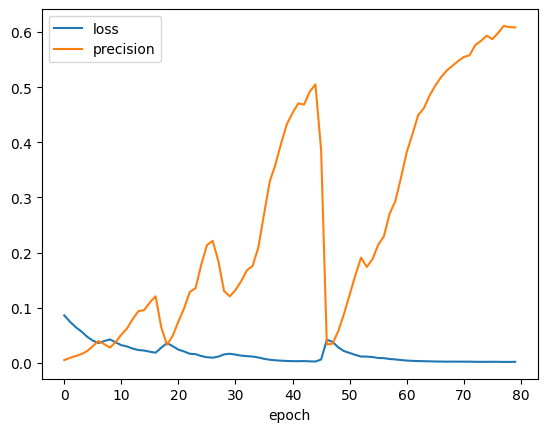

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


# Makes multiple runs comparable
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

anchors = [[16,8],[23,103],[28,23],[56,47],[96,123],[157,248]]

dataloader = torch.utils.data.DataLoader(ListDataset("Data/Finetune/train/",img_size=(384,512)), batch_size=32, shuffle=True)

model = YOLO(8,4,anchors).cuda()
model.train()

optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

train_losses = []
train_prec = []
epoch_num = 80
for epoch in range(epoch_num):

  losses = np.zeros(9)

  bar = display(progress(0, len(dataloader)), display_id=True)

  for i, (_, imgs, targets) in enumerate(dataloader):
    imgs = imgs.cuda()
    targets = targets.cuda().requires_grad_(False)

    optimizer.zero_grad()

    loss = model(imgs, targets)

    loss[0].backward()
    optimizer.step()

    losses += torch.Tensor(loss).cpu().detach().numpy()

    bar.update(progress(i+1, len(dataloader)))

  train_losses.append(losses[1]/float(len(dataloader)))
  train_prec.append(losses[8] / float(len(dataloader)))
  print(
      "[Epoch %d/%d][Losses: x %f, y %f, w %f, h %f, conf %f, cls %f, total %f, recall: %.5f, precision: %.5f]"
      % (
          epoch+1,
          epoch_num,
          losses[1] / float(len(dataloader)),
          losses[2] / float(len(dataloader)),
          losses[3] / float(len(dataloader)),
          losses[4] / float(len(dataloader)),
          losses[5] / float(len(dataloader)),
          losses[6] / float(len(dataloader)),
          losses[0] / float(len(dataloader)),
          losses[7] / float(len(dataloader)),
          losses[8] / float(len(dataloader)),
      )
  )

plt.plot(train_losses, label='loss')
plt.plot(train_prec, label='precision')
plt.xlabel('epoch')
plt.legend()
plt.show()


## Vizualizáció

### Non-maximum surpression

In [14]:
def non_max_suppression(prediction, num_classes, conf_thres=0.5, nms_thres=0.2):
  """
  Removes detections with lower object confidence score than 'conf_thres' and performs
  Non-Maximum Suppression to further filter detections.
  Returns detections with shape:
      (x1, y1, x2, y2, object_conf, class_score, class_pred)
  """

  # From (center x, center y, width, height) to (x1, y1, x2, y2)
  box_corner = prediction.new(prediction.shape)
  box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
  box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
  box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
  box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
  prediction[:, :, :4] = box_corner[:, :, :4]

  output = [None for _ in range(len(prediction))]
  for image_i, image_pred in enumerate(prediction):
    # Filter out confidence scores below threshold
    conf_mask = (image_pred[:, 4] >= conf_thres).squeeze()
    image_pred = image_pred[conf_mask]
    # If none are remaining => process next image
    if not image_pred.size(0):
      continue
    # Get score and class with highest confidence
    class_conf, class_pred = torch.max(image_pred[:, 5 : ], 1, keepdim=True)
    # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
    detections = torch.cat((image_pred[:, :5], class_conf.float(), class_pred.float()), 1)
    # Iterate through all predicted classes
    unique_labels = detections[:, -1].cpu().unique()
    if prediction.is_cuda:
      unique_labels = unique_labels.cuda()
    for c in unique_labels:
      # Get the detections with the particular class
      detections_class = detections[detections[:, -1] == c]
      # Sort the detections by maximum objectness confidence
      _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
      detections_class = detections_class[conf_sort_index]
      # Perform non-maximum suppression
      max_detections = []
      while detections_class.size(0):
        # Get detection with highest confidence and save as max detection
        max_detections.append(detections_class[0].unsqueeze(0))
        # Stop if we're at the last detection
        if len(detections_class) == 1:
            break
        # Get the IOUs for all boxes with lower confidence
        ious = bbox_iou(max_detections[-1], detections_class[1:])
        # Remove detections with IoU >= NMS threshold
        detections_class = detections_class[1:][ious < nms_thres]

      max_detections = torch.cat(max_detections).data
      # Add max detections to outputs
      output[image_i] = (
        max_detections if output[image_i] is None else torch.cat((output[image_i], max_detections))
      )

  return output

### Teszt

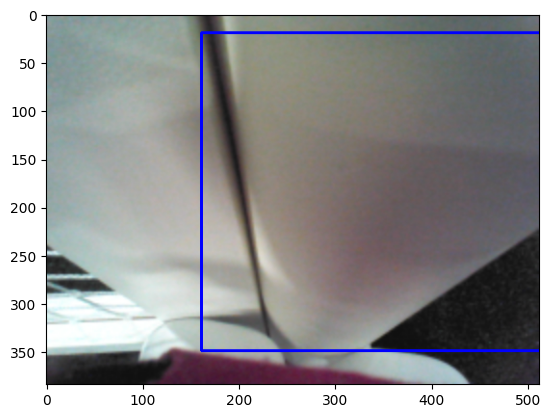

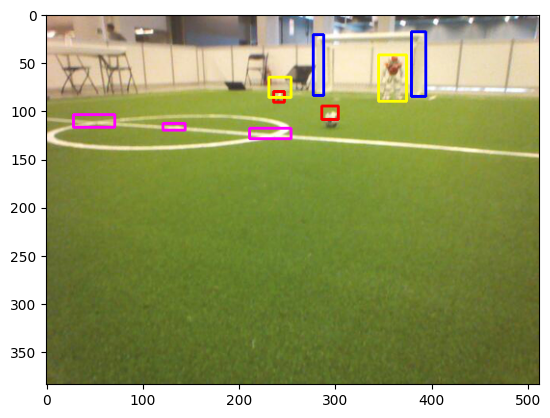

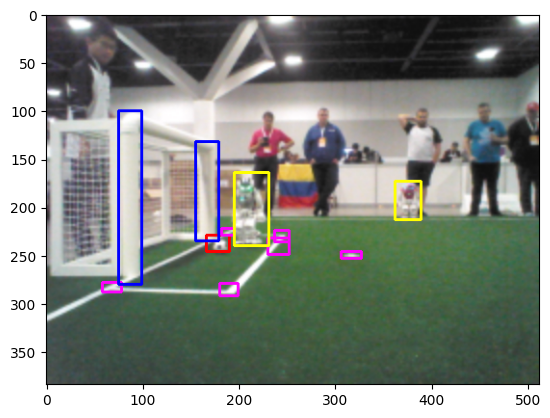

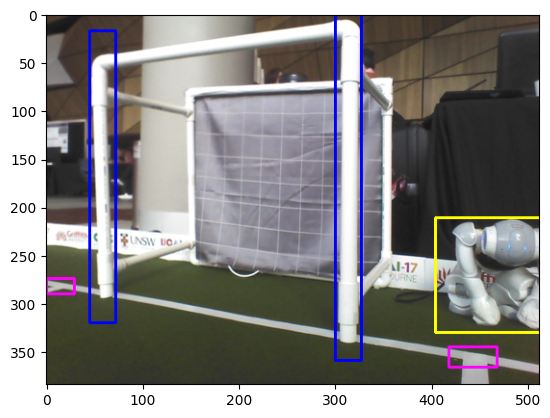

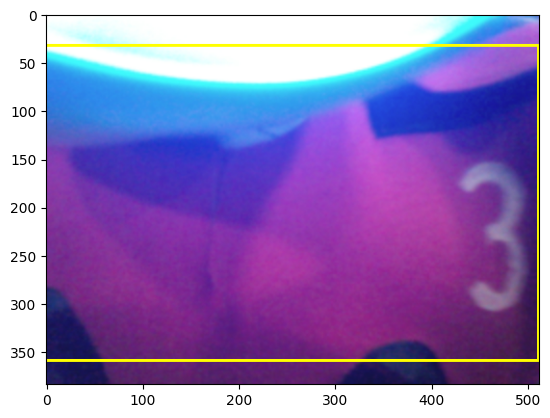

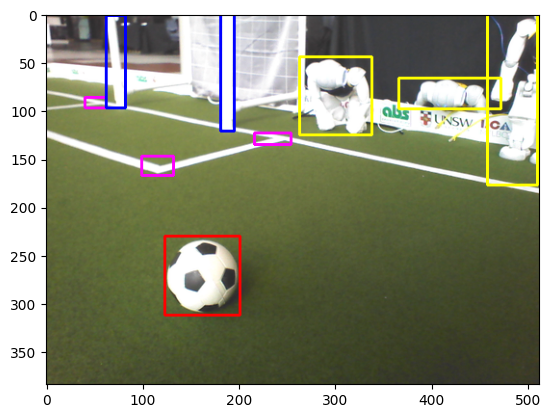

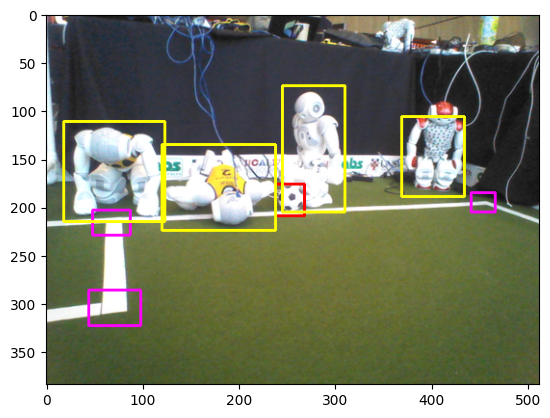

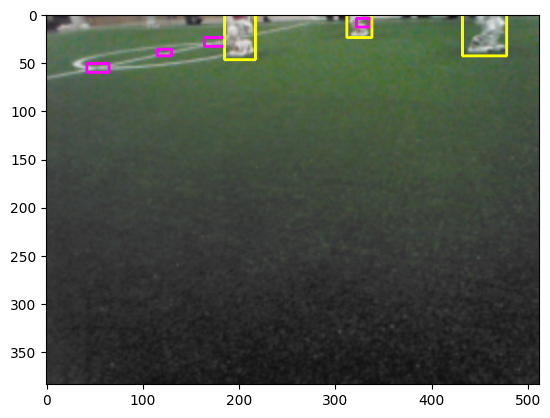

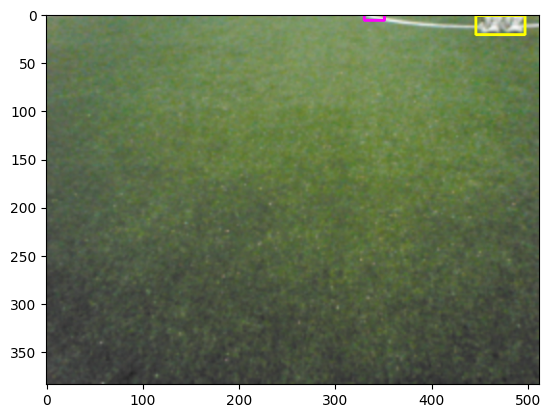

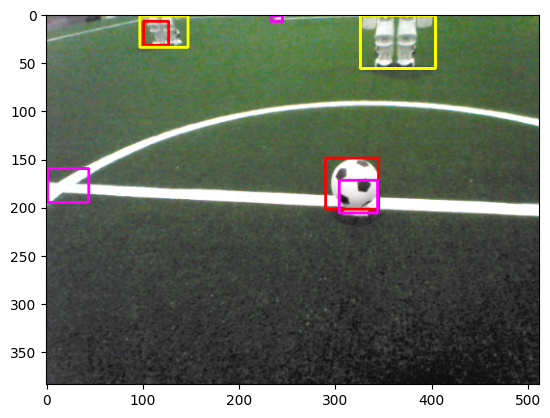

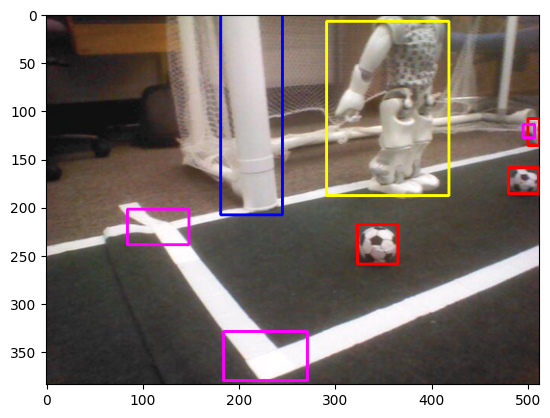

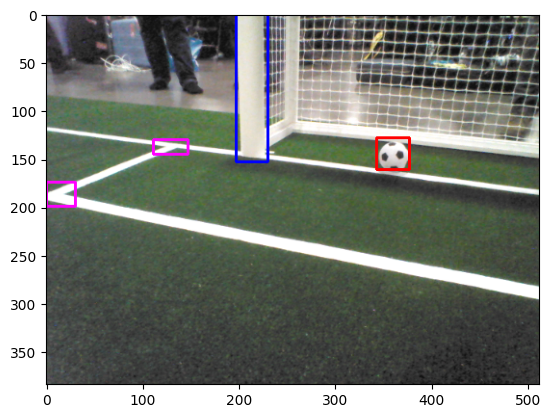

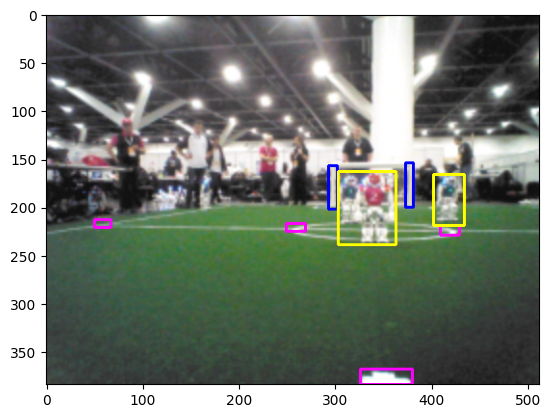

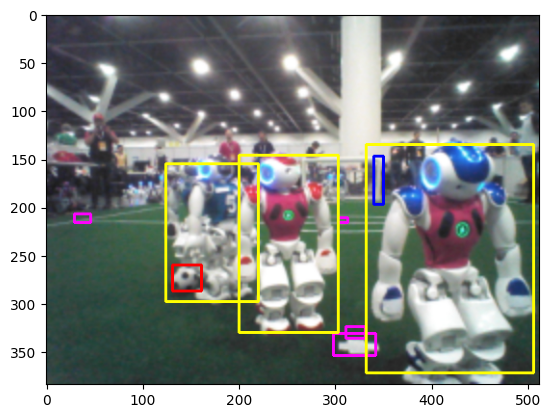

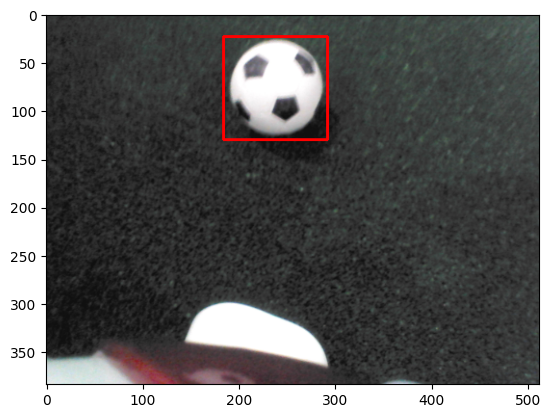

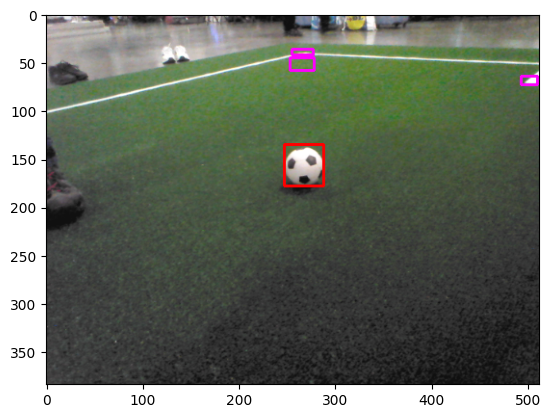

In [15]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
plt.rcParams["axes.grid"] = False

dataloader = torch.utils.data.DataLoader(ListDataset("Data/Finetune/train/",img_size=(384,512)), batch_size=16, shuffle=True)

model.eval()

for i, (paths, imgs, targets) in enumerate(dataloader):
    imgs = imgs.cuda()

    with torch.no_grad():
      detections = model(imgs)
      detections = non_max_suppression(detections, 4)

    for path,detection in zip(paths,detections):
      img = np.array(Image.open(path).convert('RGB'))
      img = cv2.cvtColor(img,cv2.COLOR_YUV2RGB)
      img = cv2.resize(img,(512,384))

      if detection is not None:
        unique_labels = detection[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = [(255,0,0),(255,0,255),(0,0,255),(255,255,0)]
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detection:

          # Rescale coordinates to original dimensions
          '''y1 = (y1) * 1.25
          x1 = (x1) * 1.25
          y2 = (y2) * 1.25
          x2 = (x2) * 1.25'''

          color = bbox_colors[int(cls_pred)]
          # Create a Rectangle patch
          cv2.rectangle(img,(int(x1),int(y1)),(int(x2),int(y2)),color,2)

      # Save generated image with detections
      plt.figure()
      imshow(img)

    plt.show()
    break